# Background : Variational Auto-Encoder (VAE) and Evidence Lower Bound (ELBO)

Before jumping into diffusion models, I'll first introduce VAE (Variational Auto-encoder) for your beginning. By seeing variational auto-encoder, you will learn fundamentals of modeling with forward process / reverse process.

Auto-encoder is a primitive model (neural network) to copy data (e.g, images) by encoder-decoder patterns, in which the encoder compresses data to the latent space and the decoder reconstructs it from the encoded objects.<br>
In VAE, the optimal probability distributions to describe variables is used instead of using variables directly. VAE is considered as a part of probabilistic graph or variational Bayesian.<br>
In this manner, VAE approximates the true distribution to draw samples.

> Note : The chapter 10 in "[Pattern Recognition and Machine Learning](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf)" (Christopher M. Bishop, Microsoft) is a good reading for understanding variational Bayesian.<br>
> See [here](https://github.com/tsmatz/gmm/) for Python example of variational Bayesian in probabilistic graph.

*(back to [index](https://github.com/tsmatz/diffusion-tutorials/))*

## Architecture

In VAE, we suppose, the distribution of generated images $p(X)$ (where $X=\{\mathbf{x}^{(i)}\}_{i=1}^N$ is a set of observed $N$ data points) is derived from the continuous latent variables $p(Z)$ (where $Z=\{\mathbf{z}^{(i)}\}_{i=1}^N$ is a set of corresponding latent variables).<br>
In this problem, however, the real distribution $p(X)$ and the hidden data points $Z=\{\mathbf{z}^{(i)}\}_{i=1}^N$ are never known. And it's then intractable to solve this problem by EM algorithm (likelihood approach).<br>
Therefore, in VAE, we apply variational Bayesian to get the optimal encoder/decoder between generated images and the latent variables, by assuming some prior distribution $p(Z)$. (See [here](https://github.com/tsmatz/gmm/) for the comparison between EM algorithm and variational Bayesian in GMM example.)

For clarification, here I'll show you with handwriting digit's images (MNIST) example.

![MNIST images](./assets/mnist_images.png)

Firstly, we suppose that the image $\mathbf{x}$ (vector) is generated by some latent variable $\mathbf{z}$ (vector).<br>
For example, each digit's image $\mathbf{x}$ (which has 28 x 28 = 786 dimension) may have been generated by supposing some digit number. In this case, the latent variable $\mathbf{z}$ can be the discrete digit number 0, 1, 2, ... , 9.

The real latent space for generating image, however, may mostly be continuous and we then consider in stochastic space.<br>
For example, the latent value of the following image may be the middle of digit 4 and 9.

![image either 4 or 9](./assets/mnist_4or9.png)

In our example, we assume the latent prior distribution $p(\mathbf{z}) = \mathcal{N}(\mathbf{0},\mathbf{I})$. (I note that here the prior distribution $p(\mathbf{z})$ doesn't have any parameters.)

> Note : In practice, the dimension of latent space should be large enough to represent the latent space.

We suppose that a value $\mathbf{x}$ is generated from some conditional distribution $p_{\theta^{\ast}}(\mathbf{x}|\mathbf{z})$, where $p_{\theta}(\mathbf{x}|\mathbf{z})$ is determined by a neural network (or a function) with parameter $\theta$, and $\theta^{\ast}$ is the optimal parameter.<br>
In our example, we suppose that $p_{\theta}(\mathbf{x}|\mathbf{z})$ is also a Gaussian distribution $p_{\theta}(\mathbf{x}|\mathbf{z}) = \mathcal{N}(\mu_{\theta}^{\verb|dec|}(\mathbf{z}),(\sigma^{\verb|dec|})^2)$ where $\sigma^{\verb|dec|}$ is some fixed value.<br>
For example, when the latetnt variable $\mathbf{z}$ represents the digit number 7, then $\mu_{\theta}^{\verb|dec|}(\mathbf{z})$ will be the vector image which represents the digit number 7.

We also consider a conditional distribution $q_{\phi}(\mathbf{z}|\mathbf{x})$, which distribution is also determined by a neural network (or a function) with parameter $\phi$.<br>
In our example, we also suppose that $q_{\phi}(\mathbf{z}|\mathbf{x})$ is a Gaussian distribution $q_{\phi}(\mathbf{z}|\mathbf{x}) = \mathcal{N}(\mu_{\phi}^{\verb|enc|}(\mathbf{x}),\verb|diag|((\sigma_{\phi}^{\verb|enc|}(\mathbf{x}))^2))$.<br>
For example, when the image vector $\mathbf{x}$ is above (the digit's image of the middle of digit 4 and 9), then $q_{\phi}(\mathbf{z}|\mathbf{x})$ represents the latent distribution of the middle of digit 4 and 9.

$q_{\phi}(\mathbf{z}|\mathbf{x})$ is called a encoder, and $p_{\theta}(\mathbf{x}|\mathbf{z})$ is called a decoder.

![VAE architecture](./assets/vae_architecture.png)

Our goal is to optimize both parameters $\phi$ and $\theta$ to maximize the log likelihood $\log p(\mathbf{x})$.

## Method

Let's briefly follow the methods to solve optimal $\phi$ and $\theta$ along with the original paper [[Diederik P. Kingma and Max Welling, 2013](https://arxiv.org/pdf/1312.6114)].

Firstly, the log likelihood of observation $p(\mathbf{x})$ is decomposed as : 

$\displaystyle \log p(\mathbf{x})$

$\displaystyle = \int \log p(\mathbf{x}) q_{\phi}(\mathbf{z}|\mathbf{x}) d\mathbf{z} $ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (because $\int q_{\phi}(\mathbf{z}|\mathbf{x}) d\mathbf{z} = 1$)

$\displaystyle = \mathbb{E}_{q_{\phi}(\mathbf{z}|\mathbf{x})}[\log p(\mathbf{x})] $

$\displaystyle = \mathbb{E}_{q_{\phi}(\mathbf{z}|\mathbf{x})}\left[\log \frac{p(\mathbf{x}, \mathbf{z})}{q_{\phi}(\mathbf{z}|\mathbf{x})}\right] + \mathbb{E}_{q_{\phi}(\mathbf{z}|\mathbf{x})}\left[\log\frac{q_{\phi}(\mathbf{z}|\mathbf{x})}{p(\mathbf{z}|\mathbf{x})}\right] $

$\displaystyle = \mathbb{E}_{q_{\phi}(\mathbf{z}|\mathbf{x})}\left[\log \frac{p(\mathbf{x}, \mathbf{z})}{q_{\phi}(\mathbf{z}|\mathbf{x})}\right] + D_{KL}\left(q_{\phi}(\mathbf{z}|\mathbf{x})\|p(\mathbf{z}|\mathbf{x})\right)$

where $p(\mathbf{z}|\mathbf{x})$ is true distribution and $D_{KL}(q\|p)$ is KL-divergence between $q$ and $p$.

When $q_{\phi}(\mathbf{z}|\mathbf{x})$ goes to true distribution, $D_{KL}\left(q_{\phi}(\mathbf{z}|\mathbf{x})\|p(\mathbf{z}|\mathbf{x})\right)$ goes to zero and then $\mathbb{E}_{q_{\phi}(\mathbf{z}|\mathbf{x})}\left[\log \frac{p(\mathbf{x}, \mathbf{z})}{q_{\phi}(\mathbf{z}|\mathbf{x})}\right]$ is a lower-bound for $\log p(\mathbf{x})$.

$\displaystyle \log p(\mathbf{x}) \geq \mathbb{E}_{q_{\phi}(\mathbf{z}|\mathbf{x})}\left[\log \frac{p(\mathbf{x}, \mathbf{z})}{q_{\phi}(\mathbf{z}|\mathbf{x})}\right]$

This right-hand side expectation (lower-bound) is called Evidence Lower Bound (ELBO) (see [here](https://github.com/tsmatz/gmm/blob/master/02-gmm-variational-inference.ipynb)), and our goal is to maximize this lower-bound in order to maximize $\log p(\mathbf{x})$ on the observed data points $\{\mathbf{x}^{(i)}\}_{i=1}^N$.

Because $p(\mathbf{x}, \mathbf{z}) = p(\mathbf{x}|\mathbf{z}) p(\mathbf{z})$, Evidence Lower Bound (ELBO) is then decomposed as follows. :

$\displaystyle \mathbb{E}_{q_{\phi}(\mathbf{z}|\mathbf{x})}\left[\log \frac{p(\mathbf{x}, \mathbf{z})}{q_{\phi}(\mathbf{z}|\mathbf{x})}\right] = \mathbb{E}_{q_{\phi}(\mathbf{z}|\mathbf{x})}[\log p_{\theta}(\mathbf{x}|\mathbf{z})] - D_{KL} \left( q_{\phi}(\mathbf{z}|\mathbf{x}) \| p(\mathbf{z}) \right)$

The second term (KL-divergence term) $D_{KL} \left( q_{\phi}(\mathbf{z}|\mathbf{x}) \| p(\mathbf{z}) \right)$ represents how the distribution $q_{\phi}(\mathbf{z}|\mathbf{x})$ is similar to the marginal distribution $p(\mathbf{z})$, and this can be easily integrated analytically, because the forms of both $q_{\phi}(\mathbf{z}|\mathbf{x})$ and $p(\mathbf{z})$ are known Gaussian distributions in this example. (See below description in the implementation.)

For the first term $\mathbb{E}_{q_{\phi}(\mathbf{z}|\mathbf{x})}[\log p_{\theta}(\mathbf{x}|\mathbf{z})]$, we should maximize the possibility $p_{\theta}(\mathbf{x}|\mathbf{z})$ for the given input $\mathbf{x}$, and we can then optimize by minimizing the difference between the reconstructed image $\hat{\mathbf{x}}$ (= $\mu_{\theta}^{\verb|dec|}(\mathbf{z})$) and the input image $\mathbf{x}$.<br>
In practice, this expectation computation requires estimation by sampling from $q_{\phi}(\mathbf{z}|\mathbf{x})$. :

$\displaystyle \mathbb{E}_{q_{\phi}(\mathbf{z}|\mathbf{x})}[\log p_{\theta}(\mathbf{x}|\mathbf{z})] \simeq \frac{1}{M} \sum_{i=1}^M \left( \frac{1}{L} \sum_{l=1}^L \left( \log p_{\theta}(\mathbf{x}^{(i)} | \mathbf{z}^{(i,l)}) \right) \right)$

where $M$ is the number of minibatch $\{\mathbf{x}^{(i)}\}_{i=1}^M$ and $L$ is the number of samples $\mathbf{z}^{(i,l)} \sim q_{\phi}(\mathbf{z}|\mathbf{x^{(i)}})$ in each $\mathbf{x}^{(i)}$.

But optimizing this term is problematic, because $q_{\phi}(\mathbf{z}|\mathbf{x})$ depends on parameter $\phi$ which should be optimized, and the gradient $\nabla_{\phi}\mathbb{E}_{q_{\phi}(\mathbf{z}|\mathbf{x})}[\cdot]$ by sampling is then intractable.

In order to solve this problem, we now apply **reparameterization** (change of parameters) trick as follows.

Let $\mathbf{z}$ be a continuous random variable with $\mathbf{z} \sim q_{\phi}(\mathbf{z}|\mathbf{x})$, and we assume that $\mathbf{z}$ can be expressed as $\mathbf{z} = g_{\phi}(\epsilon, \mathbf{x})$, where $\epsilon \sim p(\epsilon)$ is the distribution independent of parameter $\phi$, and $g_{\phi}(\cdot)$ is some vector-valued function parameterized by $\phi$.<br>
Under this assumption, we also assume that the interval satisfies $q_{\phi}(\mathbf{z}|\mathbf{x}) dz_0 dz_1 \ldots dz_{n-1} = p(\epsilon) d\epsilon_0 d\epsilon_1 \ldots d\epsilon_{n-1}$, where $\mathbf{z} = (z_0, z_1, \ldots, z_{n-1})$ and $\epsilon = (\epsilon_0, \epsilon_1, \ldots, \epsilon_{n-1})$.

> Note : In this case, it also satisfies $q_{\phi}(\mathbf{x}|\mathbf{z}) \cdot \left| \det \left( \frac{\partial \mathbf{z}}{\partial \mathbf{\epsilon}} \right) \right| = p(\mathbf{\epsilon})$, where $\frac{\partial \mathbf{z}}{\partial \mathbf{\epsilon}}$ is the Jacobian. (This is a dual condition.)<br>
> See [here](https://tutorial.math.lamar.edu/classes/calciii/changeofvariables.aspx) for the change of variables and the Jacobian.

In our example, the distribution $q_{\phi}(\mathbf{z}|\mathbf{x})$ is $\mathcal{N}(\mu_{\phi}^{\verb|enc|}(\mathbf{x}),\verb|diag|((\sigma_{\phi}^{\verb|enc|}(\mathbf{x}))^2))$ (see above), and then we can define $p(\epsilon)$ and $g_{\phi}(\epsilon, \mathbf{x})$ to satisfy above conditions as follows. :

---

<ins>reparameterization</ins>

$\displaystyle \mathbf{z} = g_{\phi}(\epsilon, \mathbf{x}) \stackrel{\mathrm{def}}{=} \mu_{\phi}^{\verb|enc|}(\mathbf{x}) + \verb|diag|(\sigma_{\phi}^{\verb|enc|}(\mathbf{x})) \odot \epsilon$

where $\epsilon \sim \mathcal{N}(\mathbf{0},\mathbf{I})$, and the second term $\verb|diag|(\sigma_{\phi}^{\verb|enc|}(\mathbf{x})) \odot \epsilon$ means element-wise multiplication between diagonal elements of $\sigma_{\phi}^{\verb|enc|}(\mathbf{x})$ and the vector $\epsilon$.

---

In this assumption, we can construct the differentiable estimator by sampling, because the following equation holds. :

$\displaystyle \mathbb{E}_{q_{\phi}(\mathbf{z}|\mathbf{x})}[f(\mathbf{z})]$

$\displaystyle =\int q_{\phi}(\mathbf{z}|\mathbf{x}) f(\mathbf{z}) d \mathbf{z}$

$\displaystyle =\int p(\epsilon) f(\mathbf{z}) d \epsilon$

$\displaystyle =\int p(\epsilon) f(g_{\phi}(\epsilon, \mathbf{x})) d \epsilon$

$\displaystyle =\mathbb{E}_{p(\epsilon)}[f(g_{\phi}(\epsilon, \mathbf{x}))]$

Now we can minimize the difference between the reconstructed image $\hat{\mathbf{x}}$ (i.e, $\mu_{\theta}^{\verb|dec|}(\mathbf{z})$) and the input image $\mathbf{x}$ by the gradient method, and we can then finally maximize above ELBO (Evidence Lower Bound) by optimizing $\phi$ and $\theta$.

## Implementation

### Build and train VAE

Before we start, we need to install the required packages.

In [ ]:
!pip install torch torchvision matplotlib

We load handwriting digit's images (MNIST) dataset and dataloader.<br>
Each batch has shape ```[batch_size, 1, 28, 28]```.

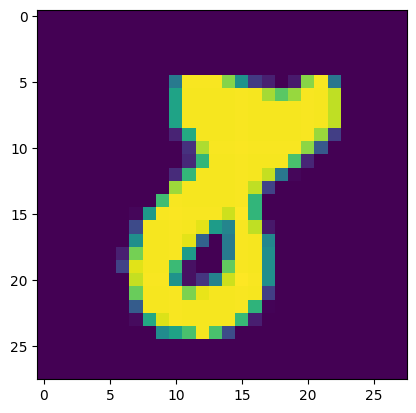

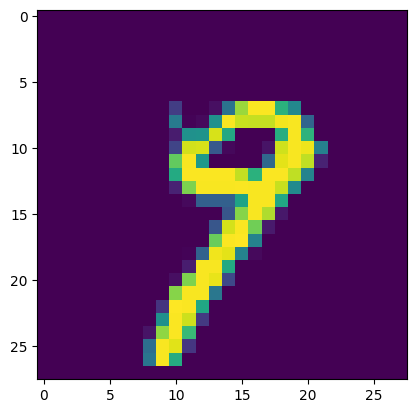

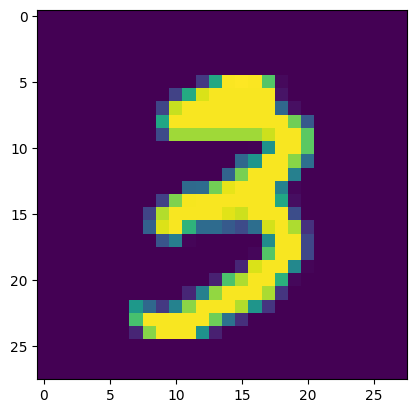

In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

batch_size = 100

dataset = datasets.MNIST(
    "./data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]))

loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# show examples
for _, (data, _) in enumerate(loader):
    images = data[:3]
    break
for i in images:
    plt.imshow(i[0].numpy())
    plt.show()

Now we build an encoder network, which outputs $\mu_{\phi}^{\verb|enc|}(\mathbf{x})$ and the diagonal elements in $\verb|diag|((\sigma_{\phi}^{\verb|enc|}(\mathbf{x}))^2)$ in the following distribution.

$q_{\phi}(\mathbf{z}|\mathbf{x}) = \mathcal{N}(\mu_{\phi}^{\verb|enc|}(\mathbf{x}),\verb|diag|((\sigma_{\phi}^{\verb|enc|}(\mathbf{x}))^2))$

In [2]:
import torch.nn as nn
from torch.nn import functional as F

latent_dim = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class EncoderNet(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        cur_dim = 64 * 7 * 7
        self.fc_mean = nn.Linear(cur_dim, latent_dim)
        self.fc_logvar = nn.Linear(cur_dim, latent_dim)

    def forward(self, x):
        x = self.conv1(x)       # --> size [batch_size, 32, 14, 14]
        x = F.relu(x)
        x = self.conv2(x)       # --> size [batch_size, 64, 7, 7]
        x = F.relu(x)
        x = torch.flatten(x, 1) # --> size [batch_size, 64*7*7]

        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar

#
# Generate a model for encoder distribution
#
encoder_net = EncoderNet(latent_dim=latent_dim).to(device)

We also build a decoder network.<br>
As we saw above, $p_{\theta}(\mathbf{x}|\mathbf{z}) = \mathcal{N}(\mu_{\theta}^{\verb|dec|}(\mathbf{z}),(\sigma^{\verb|dec|})^2)$ (where $\sigma$ is some constant) and we need to get only mean value in this network.

In [3]:
class DecoderNet(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.projection = nn.Linear(latent_dim, 64 * 7 * 7)
        self.convtrans1 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2)
        self.convtrans2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2)
        self.convtrans3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1)

    def forward(self, x):
        x = self.projection(x)               # --> size [batch_size, 64*7*7]
        x = torch.reshape(x, (-1, 64, 7, 7)) # --> size [batch_size, 64, 7, 7]
        x = self.convtrans1(x)               # --> size [batch_size, 64, 15, 15]
        x = x[:,:,:-1,:-1]                   # --> size [batch_size, 64, 14, 14] (cropping)
        x = F.relu(x)
        x = self.convtrans2(x)               # --> size [batch_size, 32, 29, 29]
        x = x[:,:,:-1,:-1]                   # --> size [batch_size, 32, 28, 28] (cropping)
        x = F.relu(x)
        x = self.convtrans3(x)               # --> size [batch_size, 1, 30, 30]
        x = x[:,:,:-2,:-2]                   # --> size [batch_size, 1, 28, 28] (cropping)
        return torch.sigmoid(x)

#
# Generate a decoder model
#
decoder_net = DecoderNet(latent_dim=latent_dim).to(device)

We compute KL-divergence (KL-loss) : $D_{KL} \left( q_{\phi}(\mathbf{z}|\mathbf{x}) \| p(\mathbf{z}) \right)$.

This value is analytically computed as follows. (See "Appendix B" in [original paper](https://arxiv.org/pdf/1312.6114).)

$\displaystyle D_{KL} \left( q_{\phi}(\mathbf{z}|\mathbf{x}) \| p(\mathbf{z}) \right)$

$\displaystyle = \int q_{\phi}(\mathbf{z}|\mathbf{x}) \log q_{\phi}(\mathbf{z}|\mathbf{x}) d\mathbf{z} - \int q_{\phi}(\mathbf{z}|\mathbf{x}) \log p(\mathbf{z}) d\mathbf{z} $

$\displaystyle = \int \mathcal{N}(\mu(\phi),\verb|diag|(\sigma(\phi)^2)) \log \mathcal{N}(\mu(\phi),\verb|diag|(\sigma(\phi)^2)) d\mathbf{z} - \int \mathcal{N}(\mu(\phi),\verb|diag|(\sigma(\phi)^2)) \log \mathcal{N}(\mathbf{0},\mathbf{I}) d\mathbf{z} $

$\displaystyle = \left( -\frac{J}{2} \log(2\pi) - \frac{1}{2} \sum_{j=1}^J (1 + \log (\sigma(\phi)_j^2)) \right) - \left( -\frac{J}{2} \log(2\pi) - \frac{1}{2} \sum_{j=1}^J (\mu(\phi)_j^2 + \sigma(\phi)_j^2) \right)$

$\displaystyle = -\frac{1}{2} \sum_{j=1}^J \left( 1 + \log (\sigma(\phi)_j^2) - \mu(\phi)_j^2 - \sigma(\phi)_j^2 \right)$

where $J$ is the dimensionality of latent space $\mathbf{z}$, and $\mu(\phi)_j$, $\sigma(\phi)_j$ are j-th elements of each vector.

In [4]:
def kl(mean, logvar):
    elements = logvar + 1.0 - mean**2 - torch.exp(logvar)
    return torch.sum(elements, dim=-1) * (-0.5)

Get samples from $q_{\phi}(\mathbf{z}|\mathbf{x})$, by applying reparameterization as follows. :

$\displaystyle \mathbf{z} = \mu_{\phi} + \sigma_{\phi}^{\verb|diag|} \odot \epsilon$

where $\epsilon \sim \mathcal{N}(\mathbf{0},\mathbf{I})$, and $\sigma_{\phi}^{\verb|diag|} \odot \epsilon$ means element-wise multiplication between $\sigma_{\phi}^{\verb|diag|}$ (diagonal elements of $\sigma_{\phi}$) and $\epsilon$.

In [5]:
# expand tensor, such as : [batch_size, latent_dim] --> [batch_size * num_sampling, latent_dim]
def expand_for_sampling(x, num_sampling):
    latent_dim = x.shape[1]

    x_sampling = x.unsqueeze(dim=1)
    x_sampling = x_sampling.expand(-1, num_sampling, -1)
    return torch.reshape(x_sampling, (-1, latent_dim))

def reparameter_sampling(mean, logvar, num_sampling):
    # expand mean : [batch_size, latent_dim] --> [batch_size * num_sampling, latent_dim]
    mean_sampling = torch.repeat_interleave(mean, num_sampling, dim=0)

    # expand logvar : [batch_size, latent_dim] --> [batch_size * num_sampling, latent_dim]
    logvar_sampling = torch.repeat_interleave(logvar, num_sampling, dim=0)

    # get epsilon
    epsilon_sampling = torch.randn_like(mean_sampling).to(device)

    return torch.mul(torch.exp(logvar_sampling*0.5), epsilon_sampling) + mean_sampling

Now we train models to optimize $\phi$ and $\theta$.

As I have mentioned [here](https://tsmatz.wordpress.com/2017/08/30/regression-in-machine-learning-math-for-beginners/), log likelihood in Gaussian is equivalent to MSE (mean square error) loss. Thus, you can also use MSE loss function instead of using ```gaussian_nll_loss()```, but please take care for the scale between reconstruction loss and KL loss in such case.

In [6]:
num_sampling = 5     # the number of sampling
num_epochs = 20

opt = torch.optim.AdamW(list(encoder_net.parameters()) + list(decoder_net.parameters()), lr=0.001)

loss_records = []
for epoch_idx in range(num_epochs):
    for batch_idx, (data, _) in enumerate(loader):
        x = data.to(device)

        opt.zero_grad()

        # get mean and logvar
        z_mean, z_logvar = encoder_net(x)
    
        # get KL-div (KL loss)
        kl_loss_batch = kl(z_mean, z_logvar) # shape: [batch_size,]
        kl_loss = torch.sum(kl_loss_batch)
    
        # sampling by reparameterization
        z_samples = reparameter_sampling(z_mean, z_logvar, num_sampling)
    
        # reconstruct x by decoder
        decoded_x_samples = decoder_net(z_samples)
        decoded_x_samples = torch.reshape(decoded_x_samples, (-1, 28*28))
    
        # get BCE loss between the input x and the reconstructed x
        x_samples = torch.repeat_interleave(x, num_sampling, dim=0)  # expand to shape: [batch_size * num_sampling, 1, 28, 28]
        x_samples = torch.reshape(x_samples, (-1, 28*28))
        pvar = torch.ones_like(x_samples).to(device) * 0.25  # sharp fit (p(x)_sigma=0.5)
        # pvar = torch.ones_like(x_samples).to(device) * 1.00  # loose fit (p(x)_sigma=1.0)
        reconstruction_loss = F.gaussian_nll_loss(
            decoded_x_samples,
            x_samples,
            var=pvar,
            reduction="sum"
        )
        reconstruction_loss /= num_sampling
        ########## for debug
        # if batch_idx == 0:
        #     print(reconstruction_loss)
        #     print(kl_loss)
    
        # optimize parameters
        total_loss = reconstruction_loss + kl_loss
        total_loss.backward()
        opt.step()
    
        # log
        loss_records.append(total_loss.item())
        print("epoch{} (iter{}) - loss {:5.4f}".format(epoch_idx, batch_idx, total_loss), end="\r")

    epoch_loss_all = loss_records[-(batch_idx+1):]
    average_loss = sum(epoch_loss_all)/len(epoch_loss_all)
    print("epoch{} (iter{}) - loss {:5.4f}".format(epoch_idx, batch_idx, average_loss))

print("Done")

epoch0 (iter599) - loss -46608.4448
epoch1 (iter599) - loss -49586.5290
epoch2 (iter599) - loss -49813.8067
epoch3 (iter599) - loss -49931.7259
epoch4 (iter599) - loss -50013.8970
epoch5 (iter599) - loss -50073.4233
epoch6 (iter599) - loss -50121.1562
epoch7 (iter599) - loss -50160.6847
epoch8 (iter599) - loss -50191.2306
epoch9 (iter599) - loss -50219.7375
epoch10 (iter599) - loss -50242.0084
epoch11 (iter599) - loss -50263.6263
epoch12 (iter599) - loss -50283.5339
epoch13 (iter599) - loss -50297.9388
epoch14 (iter599) - loss -50314.2273
epoch15 (iter599) - loss -50326.3326
epoch16 (iter599) - loss -50337.4770
epoch17 (iter599) - loss -50349.7116
epoch18 (iter599) - loss -50360.9656
epoch19 (iter599) - loss -50370.1686
Done


After the training is completed, show loss to see the training progress.

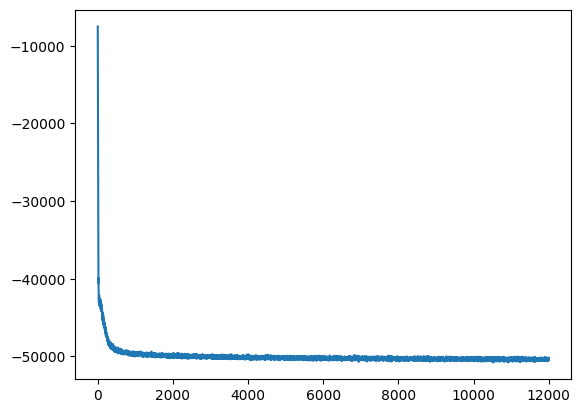

In [7]:
plt.plot(loss_records)

### Generate images

Using the trained model, let's generate images from random latent vectors. (Here I generate 5 latent vectors.)

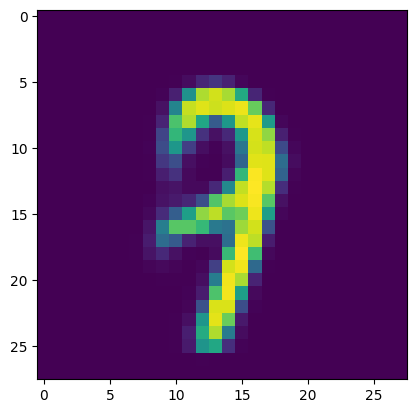

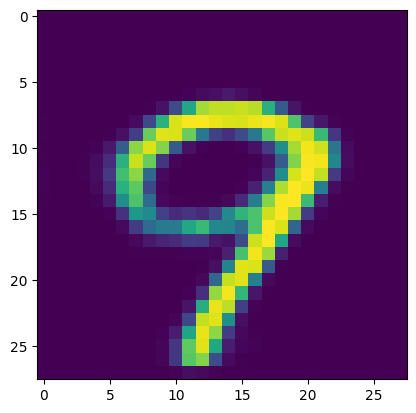

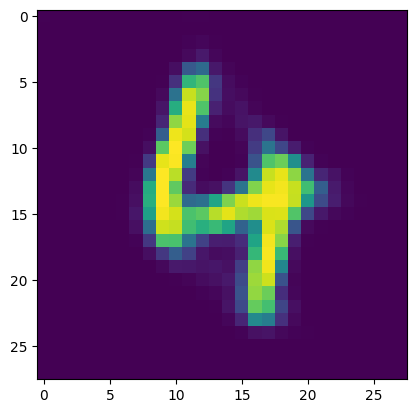

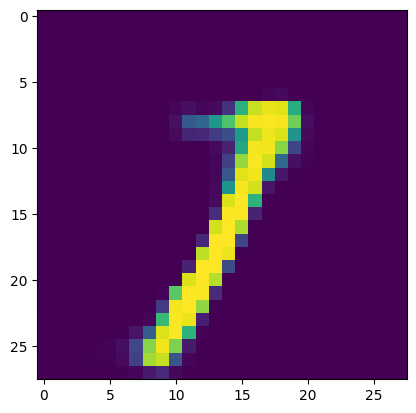

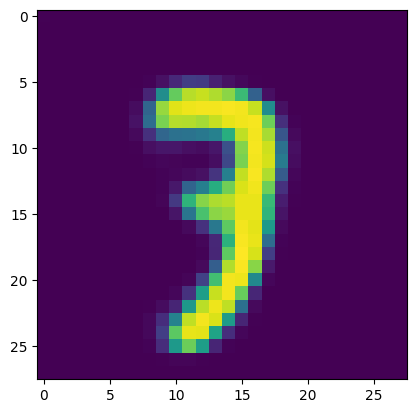

In [8]:
import matplotlib.pyplot as plt

latent_samples = torch.randn(5, latent_dim).to(device)
with torch.no_grad():
    imgs = decoder_net(latent_samples)
for i in imgs:
    plt.imshow(i[0].cpu().numpy())
    plt.show()

You can also apply variational auto-encoder (VAE) for a variety of tasks - such as, denoising, anomaly detection, etc.

Here I simply recover image without noise by applying encoding / decoding.

> Note : To construct the model for denoising, use the denoising dataset (i.e, pairs of noisy images and clean images) and train the model for denoising with VAE architecture. (Here I simply reuse above model for recovering clean image.)

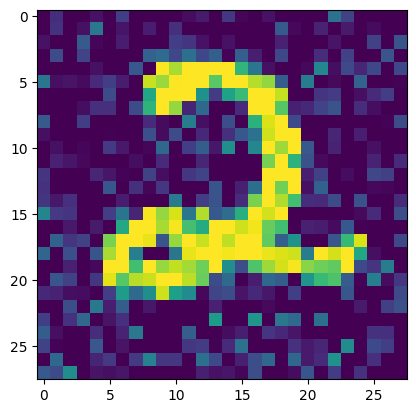

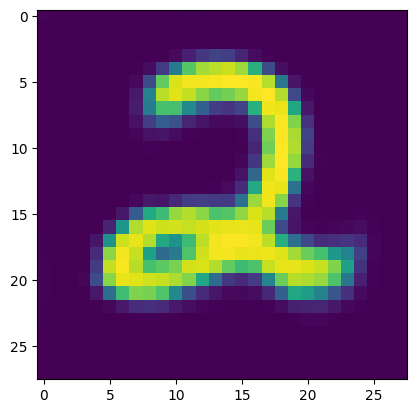

In [10]:
# make noisy image
noise_factor = 0.2
for _, (data, _) in enumerate(loader):
    data = data.to(device)
    org_image = data[0]
    noisy_image = org_image + noise_factor * torch.randn_like(org_image)
    noisy_image = torch.clamp(noisy_image, min=0.0, max=1.0)
    break

# show noisy image
plt.imshow(noisy_image[0].cpu().numpy())
plt.show()

# recover thru encoder/decoder
with torch.no_grad():
    mu, sigma = encoder_net(noisy_image.unsqueeze(dim=0))
    decoded_image = decoder_net(mu)

# show the recovered image
plt.imshow(decoded_image[0][0].cpu().numpy())
plt.show()